In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
from matplotlib import rcParams,font_manager
from matplotlib.colors import ListedColormap

from fourinarowfunctions import *

datadir = "../data/"

In [2]:
#name of your data file
filename = datadir + 'trialdata.csv'
data_dict = load_data(filename)
parsed_dict = {}
for username, data in data_dict.items():
    try:
        parsed_dict[username] = get_parsed_data(data)
    except AssertionError as e:
        print(f"Incomplete {username}: {e}")
        continue
usernames = parsed_dict.keys()
print(f"{len(usernames)} users with complete data")

drop test_im:R_2YspUds9g1Pyp6J
drop test_im:R_1LYfkmETpZRD3kn
drop debug:R_3G7Yq6aginiNva2
drop test_im2:R_2YspUds9g1Pyp6J
drop im_full_test:assign_full_test
drop test_im3:R_2YspUds9g1Pyp6J
drop null:R_emsNDLsvWMLPb7X
drop test_im_ff:test_FF_win
drop test_im_edge:test_edge_win
drop twindemo:noas
drop null:R_2qCyb2CeLwcRxH2
drop null:R_25HjvhOMhc79iaa
drop debugYZNI1G:debugDVJFSO
drop test_BO_11:R_1eXnot6X58rnPMv
drop null:R_2zhw77FMGEb36zK
drop debugOCOGDF:debug2TDLTY
drop test_im_ff2:test_FF2_win
drop null:R_2aV9fwk4CR3GjBg
drop debugQWOQ1C:debugOQ8IEY
drop CPTest:R_1QxPuBVlzMbldXa
drop CPTest:R_1FsoM2AkWpLn1Qw
drop im_full_test:ssign_full_test
drop just_a_test_:test
drop debugfull:noas
drop null:R_vou3qrtMy6aHysp
drop debugscreenshot:noas
Loaded 153 participants
Incomplete A108:R_2TnOx7dVPSonpTg: user only finished 27 games
Incomplete A123:R_2viEesh2c9XCBMe: user only finished 27 games
Incomplete A120:R_PONVLZnwDK7wSpr: user only finished 27 games
Incomplete 115:R_241tt6O6tVQs9NR: us

In [3]:
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size']

username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

In [4]:
age = pd.read_csv(datadir + "SubjectAge.csv")
pwm = pd.read_csv(datadir + "params_with_metrics.csv")
dur = pd.read_csv(datadir + "gameDurations.csv")
rts = pd.read_csv(datadir + "reactiontimes.csv")

bins = [7, 12, 18, 27]
ageBinrNr2Value = {0: 10, 1: 15, 2:22}
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
age['ageBinValue'] = age.apply(lambda row: ageBinrNr2Value.get(row['ageBinNr'], 0), axis = 1)
dur["MainDurationMinutes"] = pd.to_numeric(dur["MainDurationSeconds"]) / 60
dur["TotalDurationMinutes"] = pd.to_numeric(dur["TotalDurationSeconds"], errors='coerce') / 60
dur["StudyID"] = dur["User"].apply(lambda x: username2studyid[x])
rts["TotalMoves"] = rts["UserMoves"] + rts["OpponentMoves"]
rts["StudyID"] = rts["User"].apply(lambda x: username2studyid[x])
raw_metrics = pwm.loc[:,("subject", "fold", "planning depth", "feature drop rate", "heuristic quality", "elo")]
raw_metrics["StudyID"] = raw_metrics["subject"].apply(lambda x: username2studyid[x])
raw_metrics = pd.merge(raw_metrics, age, on="StudyID", how="left")
metrics = raw_metrics.dropna()
dropped_nans = raw_metrics[~raw_metrics.index.isin(metrics.index)]
print(f"Dropped rows with nans: {len(dropped_nans)}")
dropped_nans

Dropped rows with nans: 0


,subject,fold,planning depth,feature drop rate,heuristic quality,elo,StudyID,Gender,ExactAge,FlooredAge,ageBin,ageBinNr,ageBinValue


In [5]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8 to 12","13 to 17","18 to 27"]

rcParams['figure.figsize'] = (8,6) #figure size in inches

def set_labels(ax, title, reposition_ticks = True):
    ax.set_xlabel("Age")
    ax.set_ylabel(title)
    labels = age_labels.copy()
    if reposition_ticks:
        ax.set_xticks(list(ageBinrNr2Value.values()))
    ax.set_xticklabels(labels)
    ax.legend([])
    return ax

def plot_with_errorbars(col, title, df = None):
    if not isinstance(df, pd.DataFrame):
        df = metrics.groupby("subject").mean().reset_index()
    ax = df.groupby("ageBinValue")[col].aggregate(['mean', 'sem']).plot(yerr="sem", color='k')
    size = 20
    df.plot.scatter('ExactAge', col, size, [age_colors[int(binNr)] for binNr in df['ageBinNr']], ax=ax)
    size = 300
    df.groupby("ageBinValue")[col].aggregate(['mean']).reset_index().plot.scatter('ageBinValue', 'mean', size, age_colors, ax=ax)
    print(f"{len(df.dropna(subset=[col]))} rows used in this graph")
    set_labels(ax, title)

119 rows used in this graph


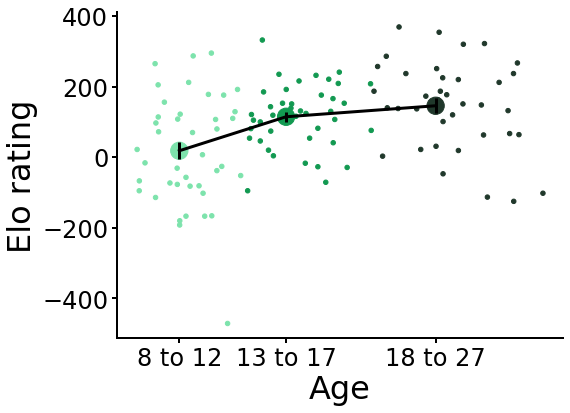

In [6]:
plot_with_errorbars("elo", "Elo rating")

119 rows used in this graph


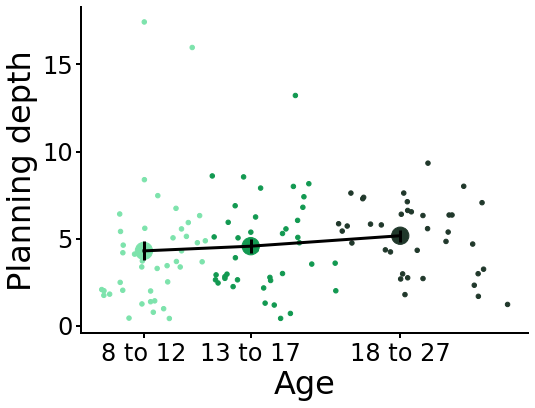

In [7]:
plot_with_errorbars("planning depth", "Planning depth")

119 rows used in this graph


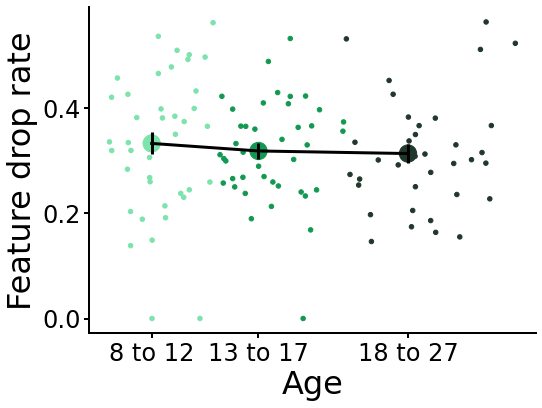

In [8]:
plot_with_errorbars("feature drop rate", "Feature drop rate")

119 rows used in this graph


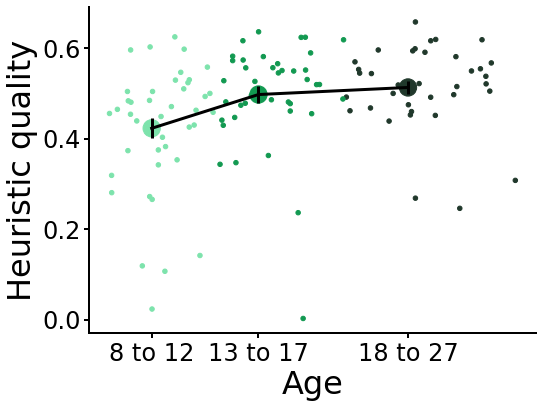

In [9]:
plot_with_errorbars("heuristic quality", "Heuristic quality")

In [10]:
durage = pd.merge(dur, age, how="left", on="StudyID")
print(f"Subjects in data: {len(durage)}")
# only include subjects listed in the first cell
durage = durage[durage["User"].isin(usernames)]
print(f"Subjects after selection: {len(durage)}")
# Remove duplicate subjects. Duplicates creep in if on or both of params_with_metrics or the age csv's contains duplicates
durage = durage.drop_duplicates(subset=["User"], keep="first")
print(f"Subjects after filtering duplicates: {len(durage)}")
# Drop subjects for which no age was available. Check that you have the expected number of subjects left!
durage = durage.dropna(subset=["ageBin"])
print(f"Subjects with age bin: {len(durage)}")

Subjects in data: 119
Subjects after selection: 119
Subjects after filtering duplicates: 119
Subjects with age bin: 119


In [11]:
rcParams['figure.figsize'] = (6,6) #figure size in inches

def plot_freq(col, title):
    plotdata = durage.groupby("ageBin")[col].aggregate(['mean', 'sem'])
    ax = plotdata.plot(kind="bar", yerr="sem", color=[age_colors])
    set_labels(ax, title, False).tick_params("x", labelrotation=0)

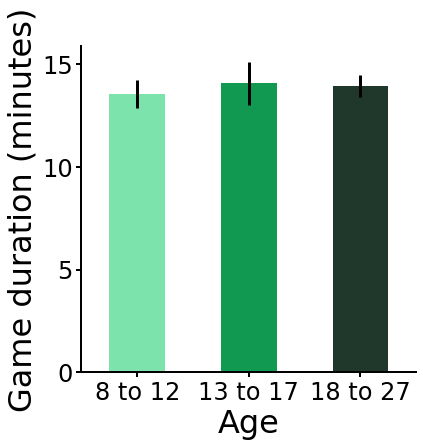

In [12]:
plot_freq("MainDurationMinutes", "Game duration (minutes)")

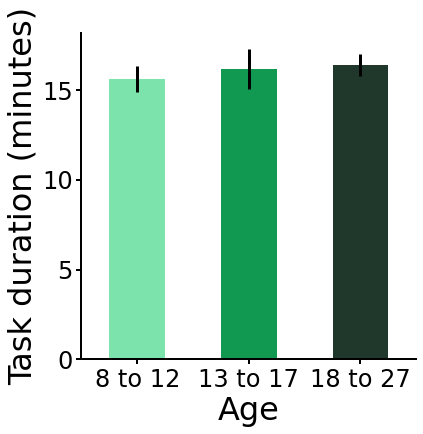

In [13]:
plot_freq("TotalDurationMinutes", "Task duration (minutes)")

In [14]:
plotdata = pd.merge(rts, age, on="StudyID", how="left")[["User", "GameNr", "TotalMoves", "ageBinNr"]].drop_duplicates()
plotdata["count"] = 1
plotdata = plotdata.groupby(["ageBinNr", "TotalMoves"])["count"].sum().reset_index().pivot(index="TotalMoves",columns="ageBinNr").fillna(0)
plotdata.loc[37] = 0 # Add an empty value at the end (36 moves is a full board)
plotdata = plotdata.sort_index()

subsPerBin = metrics[["subject", "ageBinNr"]].drop_duplicates().groupby("ageBinNr").count()
for binNr in range(len(bins) - 1):
    plotdata.iloc[:,binNr] = plotdata.iloc[:,binNr] / subsPerBin.iloc[binNr,0]

plotdata

count                    
ageBinNr           0         1         2
TotalMoves                              
6           0.000000  0.000000  0.027027
7           7.804878  7.219512  6.810811
8           4.390244  4.487805  4.378378
9           2.390244  2.804878  2.783784
10          1.951220  2.463415  1.972973
11          2.585366  3.000000  3.405405
12          1.585366  2.170732  2.594595
13          1.829268  2.195122  2.189189
14          1.975610  1.536585  1.702703
15          1.829268  1.585366  1.189189
16          1.121951  1.292683  1.027027
17          1.219512  1.268293  1.216216
18          0.926829  0.634146  1.216216
19          0.756098  0.707317  0.405405
20          0.536585  0.560976  0.648649
21          0.390244  0.439024  0.594595
22          0.365854  0.365854  0.432432
23          0.463415  0.243902  0.351351
24          0.317073  0.243902  0.216216
25          0.414634  0.317073  0.243243
26          0.146341  0.146341  0.081081
27          0.292683  0.073171  0.162162
28          0.121951  0.048780  0.162162
29          0.195122  0.121951  0.081081
30          0.170732  0.024390  0.027027
32          0.073171  0.048780  0.108108
33          0.073171  0.024390  0.027027
34          0.097561  0.000000  0.027027
35          0.024390  0.000000  0.027027
36          0.951220  0.926829  0.864865
37          0.000000  0.000000  0.000000

Text(0, 0.5, 'Average frequency')

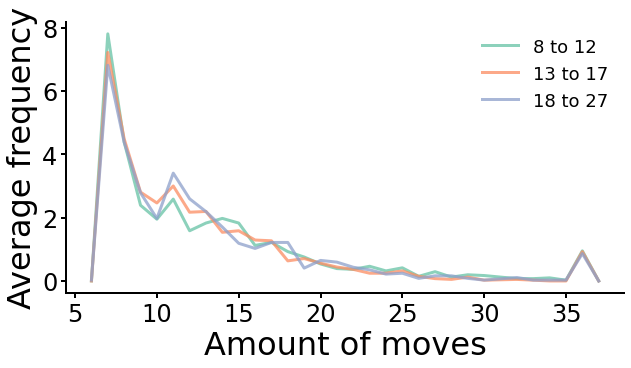

In [15]:
ax = plotdata.plot(color=["#66C2A5C0", "#FC8D62C0", "#8DA0CBC0"], figsize=(10, 5))
ax.legend(age_labels)
ax.set_xlabel("Amount of moves")
ax.set_ylabel("Average frequency")